Ứng Dụng 1: PHÂN LOẠI DỮ LIỆU ẢNH UNG THƯ VÚ SỬ DỤNG KẾT HỢP THUẬT TOÁN PHÂN TÍCH CHÙM MỜ VÀ MẠNG HỌC SÂU INCEPTION RESNET - V2

---

In [ ]:
!pip install -U scikit-fuzzy
!pip install dask[complete]
!pip install scikit-image
!pip install --upgrade tensorflow tensorflow-addons keras
!pip install tensorflow==2.15.0 tensorflow-addons==0.22.0
!pip install tensorflow h5py  

# *IMPORT CÁC THƯ VIỆN CẦN THIẾT*

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import cv2
import numpy as np
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input  # Chú ý đổi preprocess theo InceptionResNetV2
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# **`1. Chuẩn Bị Dữ Liệu (Data Preparation)`**

---

**Nhận xét về quá trình chuẩn bị dữ liệu cho dự án phân loại hình ảnh u lành tính và ác tính trong tập dữ liệu BreaKHis.**

### 1. Tải Dữ Liệu và Đếm Hình Ảnh

#### **Thông Tin Tập Train**
- **Số lượng hình ảnh lành tính:** 371
- **Số lượng hình ảnh ác tính:** 777
- **Tỷ lệ hình ảnh:** Trong tập train: 
  - Hình ảnh benign chiếm 371/1148: **32.32%**
  - Hình ảnh malignant chiếm 777/1148: **67.68%**
#### **Thông Tin Tập Test**
- **Số lượng hình ảnh lành tính:** 176
- **Số lượng hình ảnh ác tính:** 369
- **Tỷ lệ hình ảnh:** Trong tập test:
  - Hình ảnh benign chiếm 176/545: **32.29%**
  - Hình ảnh malignant chiếm 369/545: **67.71%**
#### **Tổng số ảnh**
- **Tổng: 1148 (train) + 545 (test)** = 1693 ảnh


### 2. Phân Tích Tỷ Lệ Hình Ảnh
Tỷ lệ hình ảnh lành tính và ác tính trong cả tập train và test tương đối đồng đều, với số lượng hình ảnh ác tính chiếm ưu thế. Điều này có thể cho thấy rằng dữ liệu được chuẩn bị tốt cho việc huấn luyện mô hình phân loại, nhưng cũng cần chú ý đến sự mất cân bằng trong lớp phân loại.

### 3. Kiểm Tra Kích Thước Hình Ảnh
- **Kích thước ảnh lành tính:** `(460, 700, 3)`
- **Kích thước ảnh ác tính:** `(460, 700, 3)`

Tất cả hình ảnh trong cả hai lớp đều có cùng kích thước (460x700 pixel) và số kênh màu (3 kênh cho RGB). Điều này sẽ giúp mô hình dễ dàng xử lý dữ liệu mà không cần điều chỉnh kích thước.

--------------

# **`2. Phân đoạn ảnh bằng Fuzzy C-Means (Fuzzy C-Means Segmentation)`**

---

---------------

## Tải dữ liệu ảnh đã được phân đoạn 

Số lượng hình ảnh lành tính đã được phân đoạn trong tập train: 371
Số lượng hình ảnh ác tính đã được phân đoạn trong tập train: 777
Số lượng hình ảnh lành tính đã được phân đoạn trong tập test: 176
Số lượng hình ảnh ác tính đã được phân đoạn trong tập test: 369


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


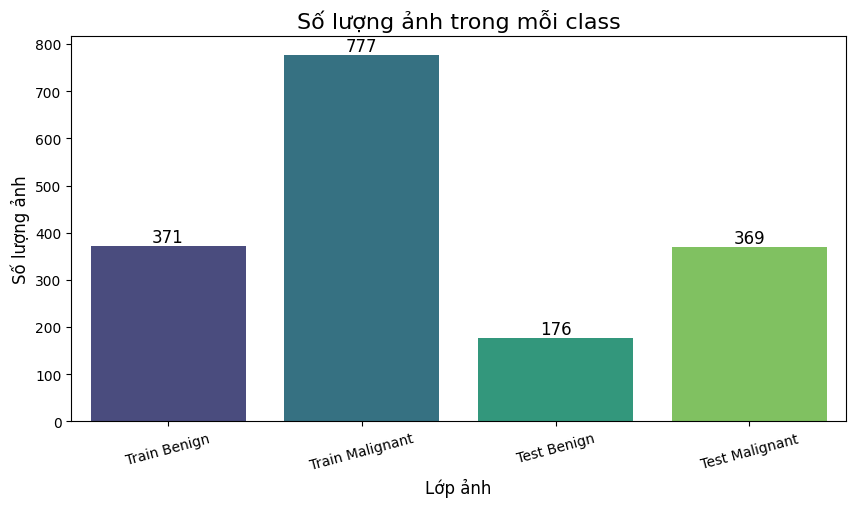

In [2]:
import seaborn as sns

# ======== Đếm số lượng ảnh trong tập train và test ========
def count_images_in_folders(train_folder, test_folder):
    # Đếm số lượng ảnh lành tính và ác tính trong tập train
    benign_folder_train = os.path.join(train_folder, "benign")
    malignant_folder_train = os.path.join(train_folder, "malignant")

    # Lấy danh sách file
    benign_images_train = os.listdir(benign_folder_train)
    malignant_images_train = os.listdir(malignant_folder_train)

    # Đếm số lượng ảnh
    num_benign_train = len(benign_images_train)
    num_malignant_train = len(malignant_images_train)

    print(f"Số lượng hình ảnh lành tính đã được phân đoạn trong tập train: {num_benign_train}")
    print(f"Số lượng hình ảnh ác tính đã được phân đoạn trong tập train: {num_malignant_train}")

    print("=" * 60)

    # Đếm số lượng ảnh lành tính và ác tính trong tập test
    benign_folder_test = os.path.join(test_folder, "benign")
    malignant_folder_test = os.path.join(test_folder, "malignant")

    # Lấy danh sách file
    benign_images_test = os.listdir(benign_folder_test)
    malignant_images_test = os.listdir(malignant_folder_test)

    # Đếm số lượng ảnh
    num_benign_test = len(benign_images_test)
    num_malignant_test = len(malignant_images_test)

    print(f"Số lượng hình ảnh lành tính đã được phân đoạn trong tập test: {num_benign_test}")
    print(f"Số lượng hình ảnh ác tính đã được phân đoạn trong tập test: {num_malignant_test}")

    return num_benign_train, num_malignant_train, num_benign_test, num_malignant_test

# ======== Vẽ biểu đồ số lượng ảnh ========
def plot_image_counts(num_benign_train, num_malignant_train, num_benign_test, num_malignant_test):
    # Kiểm tra số lượng ảnh trong từng class
    class_counts = {
        "Train Benign": num_benign_train,
        "Train Malignant": num_malignant_train,
        "Test Benign": num_benign_test,
        "Test Malignant": num_malignant_test,
    }

    # Vẽ biểu đồ số lượng ảnh
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
    plt.title("Số lượng ảnh trong mỗi class", fontsize=16)
    plt.ylabel("Số lượng ảnh", fontsize=12)
    plt.xlabel("Lớp ảnh", fontsize=12)
    plt.xticks(rotation=15)

    # Thêm số liệu lên các cột
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=12, color='black')

    plt.show()

# ======== Thực thi mã ========
train_folder = "/kaggle/input/segmented-breakhis/BreaKHis_Segmented/segmented_train"
test_folder = "/kaggle/input/segmented-breakhis/BreaKHis_Segmented/segmented_test"

# Đếm số lượng ảnh
num_benign_train, num_malignant_train, num_benign_test, num_malignant_test = count_images_in_folders(train_folder, test_folder)

# Vẽ biểu đồ số lượng ảnh
plot_image_counts(num_benign_train, num_malignant_train, num_benign_test, num_malignant_test)

In [ ]:
import os
import shutil  # <-- dòng này cần thiết
import random
import numpy as np
import threading
import queue

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
# ======== Cấu hình cơ bản ========
train_folder = "/kaggle/input/segmented-breakhis/BreaKHis_Segmented/segmented_train"
test_folder = "/kaggle/input/segmented-breakhis/BreaKHis_Segmented/segmented_test"
aug_train_dir = "augmented_train"
aug_val_dir = "augmented_val"
test_dir = "augmented_test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 2
TARGET_COUNT = 1200


In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Hàm đọc ảnh và nhãn
def load_images_and_labels(folder_path, target_size=(224, 224)):
    image_paths = []
    labels = []
    
    for label_name in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label_name)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(label_folder, filename)
                    image_paths.append(image_path)
                    labels.append(label_name)
    
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, target_size)
        images.append(img)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Đọc dữ liệu train và test
train_folder = "/kaggle/input/segmented-breakhis/BreaKHis_Segmented/segmented_train"
test_folder = "/kaggle/input/segmented-breakhis/BreaKHis_Segmented/segmented_test"

x_train, y_train = load_images_and_labels(train_folder)
x_test, y_test = load_images_and_labels(test_folder)

# Chia train và validation (80% train, 20% validation)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Chuẩn hóa ảnh về 0-1
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

# Encode nhãn
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# One-hot encoding nhãn
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

# Kiểm tra lại kích thước
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")


x_train: (918, 224, 224, 3), y_train: (918, 2)
x_val: (230, 224, 224, 3), y_val: (230, 2)
x_test: (545, 224, 224, 3), y_test: (545, 2)


# **`4. Xây dựng mô hình Inception ResNet-V2 (Building the IRV2 Model)`**

---

In [8]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load pre-trained InceptionResNetV2 without top layers
base_model = InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model layers (optional for fine-tuning later)
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
#model.summary()


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[checkpoint, earlystop]
)


Epoch 1/30
29/29 [==============================] - ETA: 0s - loss: 0.7971 - accuracy: 0.5871
Epoch 1: val_accuracy improved from -inf to 0.67391, saving model to best_model.h5
29/29 [==============================] - 31s 598ms/step - loss: 0.7971 - accuracy: 0.5871 - val_loss: 0.6923 - val_accuracy: 0.6739
Epoch 2/30
29/29 [==============================] - ETA: 0s - loss: 0.7359 - accuracy: 0.6340
Epoch 2: val_accuracy improved from 0.67391 to 0.68261, saving model to best_model.h5
29/29 [==============================] - 8s 293ms/step - loss: 0.7359 - accuracy: 0.6340 - val_loss: 0.6293 - val_accuracy: 0.6826
Epoch 3/30
29/29 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.6514
Epoch 3: val_accuracy improved from 0.68261 to 0.69130, saving model to best_model.h5
29/29 [==============================] - 8s 284ms/step - loss: 0.6850 - accuracy: 0.6514 - val_loss: 0.5966 - val_accuracy: 0.6913
Epoch 4/30
29/29 [==============================] - ETA: 0s - loss: 0

In [10]:
# Load best weights
model.load_weights("best_model.h5")

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


18/18 [==============================] - 4s 236ms/step - loss: 0.5857 - accuracy: 0.6917
Test accuracy: 0.6917


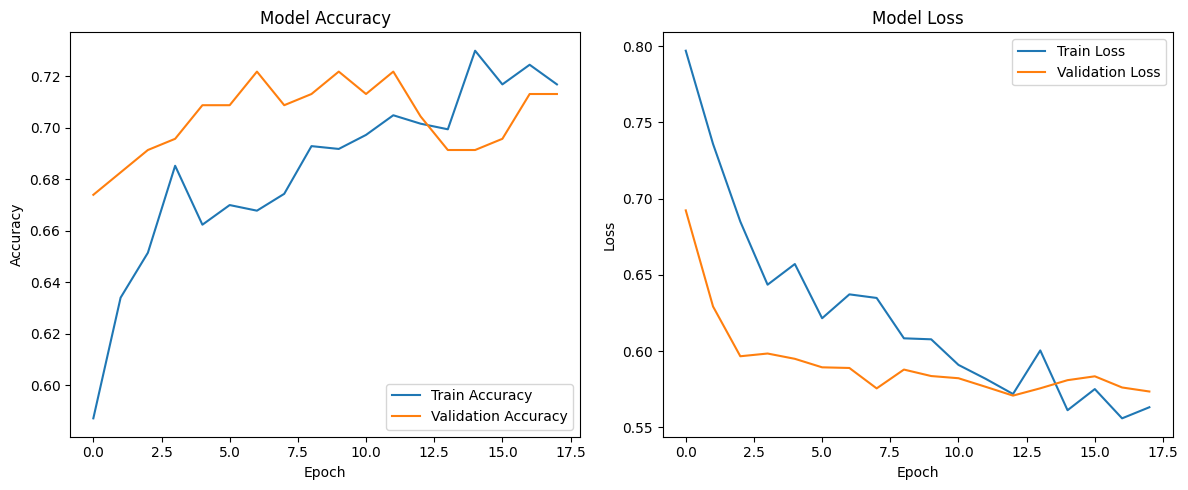

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


**ResNet50**

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet50 without top layers
base_model = ResNet50(67
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model layers (optional for fine-tuning later)
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
# model.summary()
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint, earlystop]
)


Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 0.9034 - accuracy: 0.5839
Epoch 1: val_accuracy improved from -inf to 0.67826, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 15s 291ms/step - loss: 0.9034 - accuracy: 0.5839 - val_loss: 0.6234 - val_accuracy: 0.6783
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.6209
Epoch 2: val_accuracy did not improve from 0.67826
29/29 [==============================] - 4s 133ms/step - loss: 0.7413 - accuracy: 0.6209 - val_loss: 0.6224 - val_accuracy: 0.6783
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 0.7491 - accuracy: 0.5991
Epoch 3: val_accuracy did not improve from 0.67826
29/29 [==============================] - 4s 138ms/step - loss: 0.7491 - accuracy: 0.5991 - val_loss: 0.6591 - val_accuracy: 0.6783
Epoch 4/50
29/29 [==============================] - ETA: 0s - loss: 0.7361 - accuracy: 0.6307
Epoch 4: val_accuracy did not improve from 0.67826
29/29 [==============================] - 4s 140ms/step - loss: 0.7361 - accuracy: 0.6307 - val_loss: 0.6305 - val_accuracy: 0.6783
Epoch 5/50
29/29 [======================

18/18 [==============================] - 3s 150ms/step - loss: 0.6280 - accuracy: 0.6771
Test accuracy: 0.6771


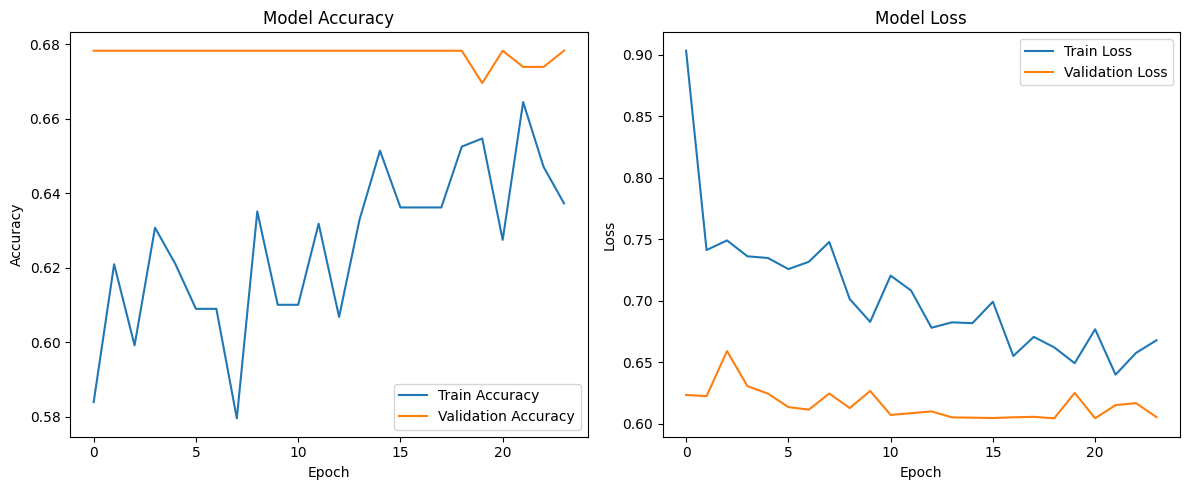

In [5]:
# Load best weights
model.load_weights("best_model.h5")

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()



**DenseNet**

In [6]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load pre-trained DenseNet121 without top layers
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model layers (optional for fine-tuning later)
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint, earlystop]
)

# Optional: model summary
# model.summary()


29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 1.0044 - accuracy: 0.5643
Epoch 1: val_accuracy improved from -inf to 0.58696, saving model to best_model.h5
29/29 [==============================] - 23s 457ms/step - loss: 1.0044 - accuracy: 0.5643 - val_loss: 0.6899 - val_accuracy: 0.5870
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.8092 - accuracy: 0.6046
Epoch 2: val_accuracy improved from 0.58696 to 0.68261, saving model to best_model.h5
29/29 [==============================] - 5s 166ms/step - loss: 0.8092 - accuracy: 0.6046 - val_loss: 0.7007 - val_accuracy: 0.6826
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 0.7844 - accuracy: 0.6068
Epoch 3: val_accuracy did not improve from 0.68261
29/29 [==============================] - 4s 145ms/step - loss: 0.7844 - accuracy: 0.6068 - val_loss: 0.6839 - val_accuracy: 0.6826
Epoch 4/50
29/29 [=====================

18/18 [==============================] - 3s 195ms/step - loss: 0.5803 - accuracy: 0.6881
Test accuracy: 0.6881


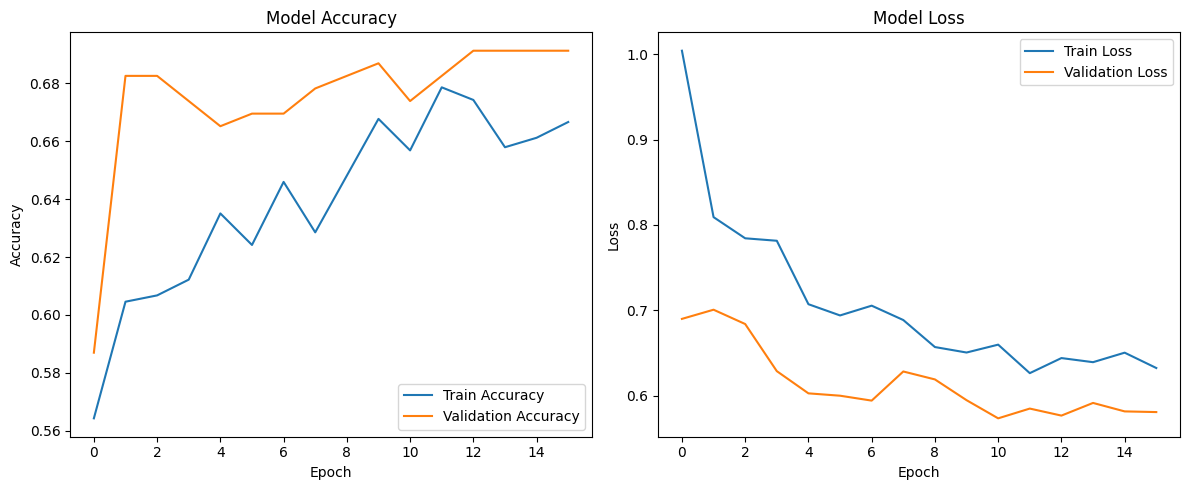

In [7]:
# Load best weights
model.load_weights("best_model.h5")

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()



**CNN**

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define custom CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and dense layers
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint, earlystop]
)

# Optional: model summary
# model.summary()


Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 0.7788 - accuracy: 0.6176
Epoch 1: val_accuracy improved from -inf to 0.67826, saving model to best_model.h5
29/29 [==============================] - 10s 199ms/step - loss: 0.7788 - accuracy: 0.6176 - val_loss: 0.6298 - val_accuracy: 0.6783
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.6325 - accuracy: 0.6732
Epoch 2: val_accuracy did not improve from 0.67826
29/29 [==============================] - 2s 70ms/step - loss: 0.6325 - accuracy: 0.6732 - val_loss: 0.6462 - val_accuracy: 0.6783
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 0.6188 - accuracy: 0.6765
Epoch 3: val_accuracy did not improve from 0.67826
29/29 [==============================] - 2s 71ms/step - loss: 0.6188 - accuracy: 0.6765 - val_loss: 0.6301 - val_accuracy: 0.6783
Epoch 4/50
29/29 [==============================] - ETA: 0s - loss: 0.6083 - accuracy: 0.6765
Epoch 4: val_accuracy did not improve from 0.67

18/18 [==============================] - 1s 27ms/step - loss: 0.6313 - accuracy: 0.6771
Test accuracy: 0.6771


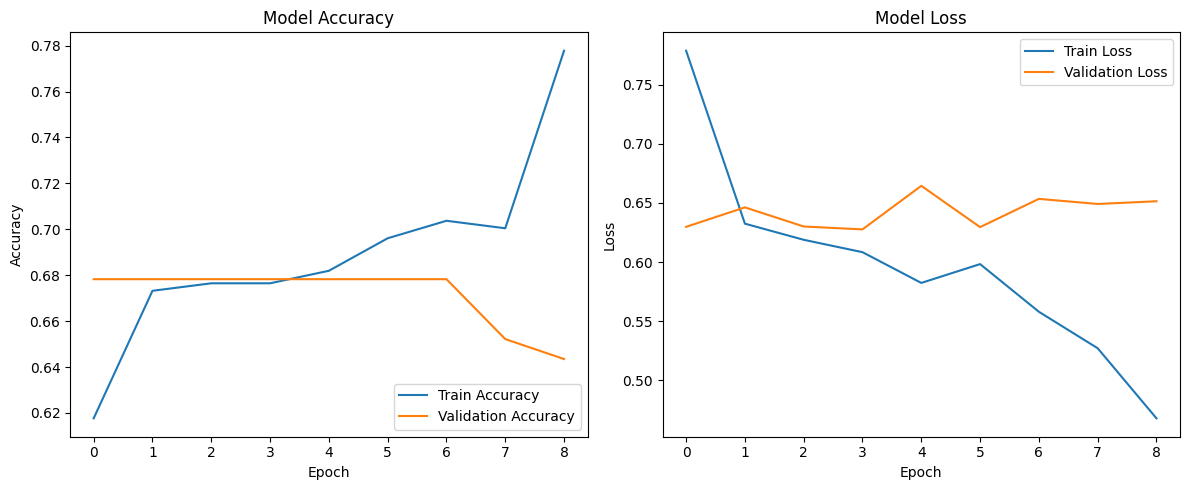

In [13]:
# Load best weights
model.load_weights("best_model.h5")

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

